In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import Scripts.airfoil as af
import Scripts.surfaceAreaEstimators as sea
import Scripts.volumeEstimators as ve
import Scripts.cotEstimators as ce

from pathlib import Path

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t

from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

In [2]:
def power_law(xData, a, b):
        return a * xData ** b

def fit_data(xData, yData):

    popt, pcov = curve_fit(power_law, xData, yData, p0=[1, 1])

    residuals = yData - power_law(xData, *popt)

    ss_res = np.sum(residuals**2)
    ss_total = np.sum((yData-np.mean(yData))**2)

    r_squared = 1 - (ss_res/ss_total)

    return popt, r_squared

In [3]:
dataBase = r'./PhillipsFitData.xlsx'
phillipsData = r'./phillips_COT_data.xlsx'
robotData = r'./PowerAndThrustData.xlsx'
figurePath = r'./Figures'

In [4]:
# Phillips COT data
totalCOT = pd.read_excel(phillipsData, sheet_name="TotalCOTData")
optCOT = pd.read_excel(phillipsData, sheet_name="OptimumCOT")
hotelpower = pd.read_excel(phillipsData, sheet_name="HotelPower")
BMR = pd.read_excel(phillipsData, sheet_name="BMR")


In [5]:
mammal_hp = BMR.loc[BMR['Species']=='Mammal']
eel_hp = BMR.loc[BMR['Species']=='Eel']
salmon_hp = BMR.loc[BMR['Species']=='Salmonoid']
AUV_hp = BMR.loc[BMR['Species']=='AUV']
glider_hp = BMR.loc[BMR['Species']=='Glider']

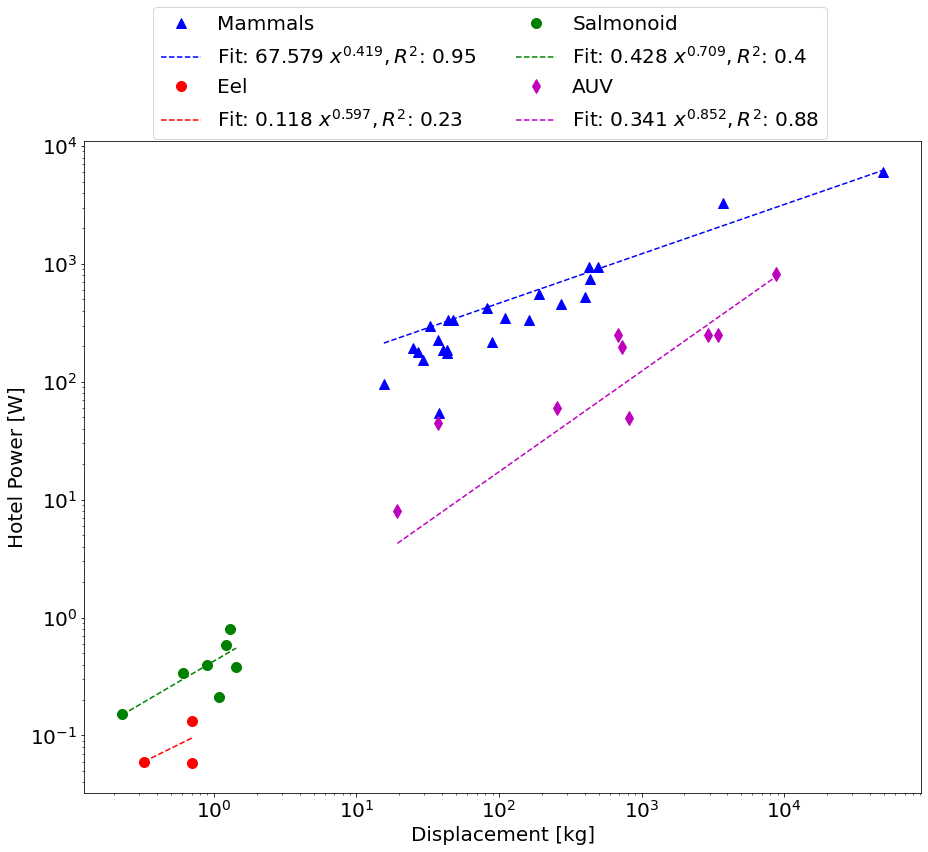

In [6]:
plt.rcParams.update({'font.size': 20, 'lines.markersize':10})

popt_mammal, r_sq_mammal = fit_data(mammal_hp["Displacement"].values, mammal_hp["MR"].values)
popt_eel, r_sq_eel = fit_data(eel_hp["Displacement"].values, eel_hp["MR"].values)
popt_salmon, r_sq_salmon = fit_data(salmon_hp["Displacement"].values, salmon_hp["MR"].values)
popt_AUV, r_sq_AUV = fit_data(AUV_hp["Displacement"].values, AUV_hp["MR"].values)
#popt_glider, r_sq_glider = fit_data(glider_hp["Displacement"].values, glider_hp["MR"].values)


fig3, ax3 = plt.subplots(figsize=((15, 12)))
fig3.set_facecolor('white')
ax3.loglog(mammal_hp["Displacement"].values, mammal_hp["MR"].values, 'b^', label='Mammals')
ax3.loglog(mammal_hp["Displacement"].values, power_law(mammal_hp["Displacement"].values, *popt_mammal), 'b--', label="Fit: " + str(np.round(popt_mammal[0], 3)) + " $x^{" + str(np.round(popt_mammal[1], 3)) + '}, R^2$: ' + str(np.round(r_sq_mammal, 2)))
ax3.loglog(eel_hp["Displacement"].values, eel_hp["MR"].values, 'ro', label='Eel')
ax3.loglog(eel_hp["Displacement"].values, power_law(eel_hp["Displacement"].values, *popt_eel), 'r--', label="Fit: " + str(np.round(popt_eel[0], 3)) + " $x^{" + str(np.round(popt_eel[1], 3)) + '}, R^2$: ' + str(np.round(r_sq_eel, 2)))
ax3.loglog(salmon_hp["Displacement"].values, salmon_hp["MR"].values, 'go', label='Salmonoid')
ax3.loglog(salmon_hp["Displacement"].values, power_law(salmon_hp["Displacement"].values, *popt_salmon), 'g--', label="Fit: " + str(np.round(popt_salmon[0], 3)) + " $x^{" + str(np.round(popt_salmon[1], 3)) + '}, R^2$: ' + str(np.round(r_sq_salmon, 2)))
ax3.loglog(AUV_hp["Displacement"].values, AUV_hp["MR"].values, 'md', label='AUV')
ax3.loglog(AUV_hp["Displacement"].values, power_law(AUV_hp["Displacement"].values, *popt_AUV), 'm--', label="Fit: " + str(np.round(popt_AUV[0], 3)) + " $x^{" + str(np.round(popt_AUV[1], 3)) + '}, R^2$: ' + str(np.round(r_sq_AUV, 2)))
ax3.set_ylabel('Hotel Power [W]')
ax3.set_xlabel('Displacement [kg]')
ax3.legend(ncol=2, bbox_to_anchor=(0.9, 1.22))
#fig3.savefig(Path(figurePath).joinpath('hotel_power.pdf'), facecolor='w', bbox_inches='tight', dpi=300)

In [7]:
def get_hotel_power(mass, animal_type):
    if(animal_type == 'Mammal'):
        return 67.579*mass**0.419
    elif(animal_type == 'Eel'):
        return 0.118*mass**0.597
    elif(animal_type == 'Salmonoid'):
        return 0.428*mass**0.709
    elif(animal_type == "AUV"):
        0.341*mass**0.852
    else:
        return 3.39*mass**0.75

In [8]:
cot_all_temp = {"Animal":[], "Length":[], "Displacement":[], "CalcDisplacement":[], "Velocity":[], "COT_Raw":[], "Re":[],  "D_calc":[], "SR":[], "COT_calc":[], "COT_Ellipse":[]}
efficiency = 0.81
kinVisc = 1.19e-6
fluidDensity = 1025
animals = totalCOT["Animal"]

for idy, animal in enumerate(animals):
    animal_type = totalCOT.loc[[idy],["Type"]].values[0]
    displacement = totalCOT.loc[[idy],["Displacement"]].values[0]
    length = totalCOT.loc[[idy],["Length"]].values[0]
    velocity = totalCOT.loc[[idy],["Velocity"]].values[0]
    sidePolyTop = totalCOT.loc[[idy],['Ta6', 'Ta5', 'Ta4', 'Ta3', 'Ta2', 'Ta1', 'Ta0']].values[0]
    sidePolyBottom = totalCOT.loc[[idy],['Ba6', 'Ba5', 'Ba4', 'Ba3', 'Ba2', 'Ba1', 'Ba0']].values[0]
    topNaca = totalCOT.loc[[idy], ['Nta4', 'Nta3', 'Nta2']].values[0]
    sideArea = totalCOT.loc[[idy], ['Side Area']].values[0]
    topArea = totalCOT.loc[[idy], ['Top Area']].values[0]
    Re = totalCOT.loc[[idy], ['Re']].values[0]
    cot_raw = totalCOT.loc[[idy],['COT']].values[0]
     
    surfaceArea, D_calc = sea.determine_surface_area(1, 2, 0, length*0.90, sidePolyTop, sidePolyBottom, topNaca, topNaca)
    surfaceArea = surfaceArea + (surfaceArea * topArea)
    
    volume, _, _ = ve.determine_volume(1, 2, 0, length*0.90, sidePolyTop, sidePolyBottom, topNaca, topNaca)
    calc_mass = volume*fluidDensity
    
    ellipseSA, ellipseD_calc, ellipseSR = sea.equivalentSpheroid(length, displacement, fluidDensity)
    SR = length/D_calc

    pp_calc = ce.ITTC_pp(SR, surfaceArea, length, displacement, efficiency, kinVisc, fluidDensity, velocity)
    ellipse_pp_calc = ce.ITTC_pp(ellipseSR, ellipseSA, length, displacement, efficiency, kinVisc, fluidDensity, velocity)
    hotel_power = get_hotel_power(displacement, animal_type)
    cot_calc = (hotel_power + pp_calc)/(displacement*velocity)
    cot_ellipse = (hotel_power + ellipse_pp_calc)/(displacement*velocity)

    cot_all_temp['Animal'].append(animal)
    cot_all_temp["Length"].append(length[0])
    cot_all_temp["Displacement"].append(displacement[0])
    cot_all_temp["CalcDisplacement"].append(calc_mass)
    cot_all_temp["Velocity"].append(velocity[0])
    cot_all_temp["COT_Raw"].append(cot_raw[0])
    cot_all_temp["Re"].append(Re[0])
    cot_all_temp["D_calc"].append(D_calc)
    cot_all_temp["SR"].append(SR[0])
    cot_all_temp["COT_calc"].append(cot_calc[0])
    cot_all_temp["COT_Ellipse"].append(cot_ellipse[0])

cot_all_data = pd.DataFrame(cot_all_temp)

In [9]:
 killerWhale_cot = cot_all_data.loc[(cot_all_data["Animal"] == "orca")]
 carp_cot = cot_all_data.loc[(cot_all_data["Animal"] == "commonCarp")]
 sturgeon_cot = cot_all_data.loc[(cot_all_data["Animal"] == "greenSturgeon")]
 silverEel_cot = cot_all_data.loc[(cot_all_data["Animal"] == "silverEel")]
 harbourSeal_cot = cot_all_data.loc[(cot_all_data["Animal"] == "harbourSeal")]
 kerala_cot = cot_all_data.loc[(cot_all_data["Animal"] == "keralaMystus")]
 sockeyeSalmon_cot = cot_all_data.loc[(cot_all_data["Animal"] == "sockeyeSalmon")]
 atlanticSalmon_cot = cot_all_data.loc[(cot_all_data["Animal"] == "atlanticSalmon")]

In [10]:
popt_orca, r_sq_orca = fit_data(killerWhale_cot["Velocity"].values, killerWhale_cot["COT_Raw"].values)
popt_carp, r_sq_carp = fit_data(carp_cot["Velocity"].values, carp_cot["COT_Raw"].values)
popt_sturgeon, r_sq_sturgeon = fit_data(sturgeon_cot["Velocity"].values, sturgeon_cot["COT_Raw"].values)
popt_silverEel, r_sq_silverEel = fit_data(silverEel_cot["Velocity"].values, silverEel_cot["COT_Raw"].values)
popt_harbourSeal, r_sq_harbourSeal= fit_data(harbourSeal_cot["Velocity"].values, harbourSeal_cot["COT_Raw"].values)
popt_kerala, r_sq_kerala = fit_data(kerala_cot["Velocity"].values, kerala_cot["COT_Raw"].values)
popt_sockeyeSalmon, r_sq_sockeyeSalmon = fit_data(sockeyeSalmon_cot["Velocity"].values, sockeyeSalmon_cot["COT_Raw"].values)
popt_atlanticSalmon, r_sq_atlanticSalmon = fit_data(atlanticSalmon_cot["Velocity"].values, atlanticSalmon_cot["COT_Raw"].values)


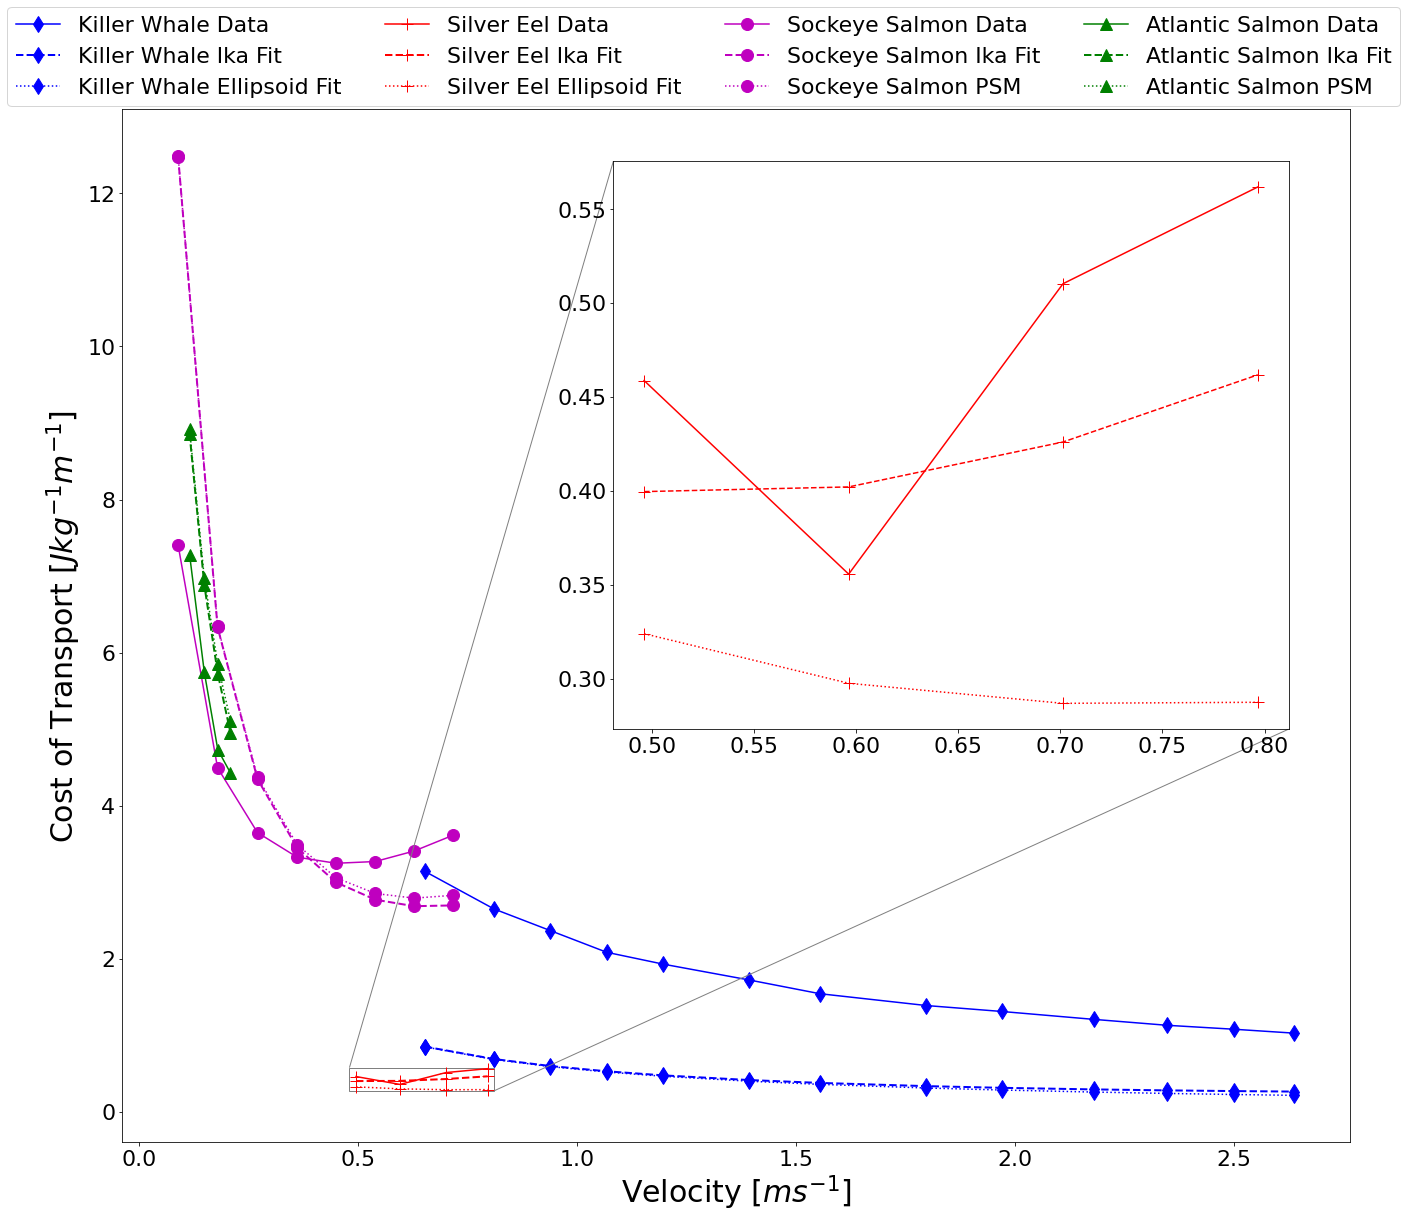

In [11]:
plt.rcParams.update({'font.size': 22, 'lines.markersize':12})
fig4, ax4 = plt.subplots(figsize=(22,19))
# Orca Data
ax4.plot(killerWhale_cot["Velocity"], killerWhale_cot["COT_Raw"], 'bd-', label='Killer Whale Data')
#ax4.plot(killerWhale_cot["Velocity"].values, power_law(killerWhale_cot["Velocity"].values, *popt_orca), 'b-')
ax4.plot(killerWhale_cot["Velocity"], killerWhale_cot["COT_calc"], 'bd--', label="Killer Whale Ika Fit", linewidth=2)
ax4.plot(killerWhale_cot["Velocity"], killerWhale_cot["COT_Ellipse"], 'bd:', label="Killer Whale Ellipsoid Fit")

# Carp Data
#ax4.plot(carp_cot["Velocity"], carp_cot["COT_Raw"], 'co')
#ax4.plot(carp_cot["Velocity"].values, power_law(carp_cot["Velocity"].values, *popt_carp), 'c-', label='Carp Data')
#ax4.plot(carp_cot["Velocity"], carp_cot["COT_calc"], 'co--', label="Carp Ika Fit", linewidth=2)
#ax4.plot(carp_cot["Velocity"], carp_cot["COT_Ellipse"], 'co:', label="Carp Ellipsoid Fit")

# Sturgeon Data
#ax4.plot(sturgeon_cot["Velocity"], sturgeon_cot["COT_Raw"], 'y^')
#ax4.plot(sturgeon_cot["Velocity"].values, power_law(sturgeon_cot["Velocity"].values, *popt_sturgeon), 'y-', label='Sturgeon Data')
#ax4.plot(sturgeon_cot["Velocity"], sturgeon_cot["COT_calc"], 'y^--', label="Sturgeon Ika Fit", linewidth=2)
#ax4.plot(sturgeon_cot["Velocity"], sturgeon_cot["COT_Ellipse"], 'y^:', label="Sturgeon Ellipsoid Fit")

# Silver Eel Data
ax4.plot(silverEel_cot["Velocity"], silverEel_cot["COT_Raw"], 'r+-', label='Silver Eel Data')
#ax4.plot(silverEel_cot["Velocity"].values, power_law(silverEel_cot["Velocity"].values, *popt_silverEel), 'r-')
ax4.plot(silverEel_cot["Velocity"], silverEel_cot["COT_calc"], 'r+--', label="Silver Eel Ika Fit", linewidth=2)
ax4.plot(silverEel_cot["Velocity"], silverEel_cot["COT_Ellipse"], 'r+:', label="Silver Eel Ellipsoid Fit")

# Kerala Data
#ax4.plot(kerala_cot["Velocity"], kerala_cot["COT_Raw"], 'mo-')
#ax4.plot(kerala_cot["Velocity"].values, power_law(kerala_cot["Velocity"].values, *popt_kerala), 'm-', label='Kerala Mystus Data')
#ax4.plot(kerala_cot["Velocity"], kerala_cot["COT_calc"], 'mo--', label="Kerala Mystus Ika Fit", linewidth=2)
#ax4.plot(kerala_cot["Velocity"], kerala_cot["COT_Ellipse"], 'mo:', label="Kerala Mystus Ellipsoid Fit")

# Sockeye Salmon Data
ax4.plot(sockeyeSalmon_cot["Velocity"], sockeyeSalmon_cot["COT_Raw"], 'mo-', label='Sockeye Salmon Data')
#ax4.plot(sockeyeSalmon_cot["Velocity"].values, power_law(sockeyeSalmon_cot["Velocity"].values, *popt_sockeyeSalmon), 'm-')
ax4.plot(sockeyeSalmon_cot["Velocity"], sockeyeSalmon_cot["COT_calc"], 'mo--', label="Sockeye Salmon Ika Fit", linewidth=2)
ax4.plot(sockeyeSalmon_cot["Velocity"], sockeyeSalmon_cot["COT_Ellipse"], 'mo:', label="Sockeye Salmon PSM")

# Atlantic Salmon Data
ax4.plot(atlanticSalmon_cot["Velocity"], atlanticSalmon_cot["COT_Raw"], 'g^-', label='Atlantic Salmon Data')
#ax4.plot(atlanticSalmon_cot["Velocity"].values, power_law(atlanticSalmon_cot["Velocity"].values, *popt_atlanticSalmon), 'g-')
ax4.plot(atlanticSalmon_cot["Velocity"], atlanticSalmon_cot["COT_calc"], 'g^--', label='Atlantic Salmon Ika Fit', linewidth=2)
ax4.plot(atlanticSalmon_cot["Velocity"], atlanticSalmon_cot["COT_Ellipse"], 'g^:', label="Atlantic Salmon PSM")

ax4.set_xlabel("Velocity $[ms^{-1}]$", fontsize=30)
ax4.set_ylabel("Cost of Transport $[Jkg^{-1}m^{-1}]$", fontsize=30)
ax4.legend(loc='best', ncol=4, bbox_to_anchor=(1.05, 1.11))

ax5 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax4, [0.4,0.4,0.55,0.55])
ax5.set_axes_locator(ip)
mark_inset(ax4, ax5, loc1=2, loc2=4, fc="none", ec='0.5')

#ax5.plot(killerWhale_cot["Velocity"], killerWhale_cot["COT_Raw"], 'bd')
#ax5.plot(killerWhale_cot["Velocity"].values, power_law(killerWhale_cot["Velocity"].values, *popt_orca), 'b-', label='Killer Whale Data')
#ax5.plot(killerWhale_cot["Velocity"], killerWhale_cot["COT_Ellipse"], 'bd:', label="Killer Whale Ellipsoid Fit")
#ax5.plot(killerWhale_cot["Velocity"], killerWhale_cot["COT_calc"], 'bd--', label="Killer Whale Ika Fit")

ax5.plot(silverEel_cot["Velocity"], silverEel_cot["COT_Raw"], 'r+-')
#ax5.plot(silverEel_cot["Velocity"].values, power_law(silverEel_cot["Velocity"].values, *popt_silverEel), 'r-')
ax5.plot(silverEel_cot["Velocity"], silverEel_cot["COT_Ellipse"], 'r+:')
ax5.plot(silverEel_cot["Velocity"], silverEel_cot["COT_calc"], 'r+--')

#fig4.savefig(Path(figurePath).joinpath('Full_COT.pdf'), facecolor='w', bbox_inches='tight', dpi=300)

In [12]:
# Robot fit data
robotData_cot = pd.read_excel(Path(robotData), sheet_name='compiledData')

robotData_cot.head()

,Name,Displacement,Velocity,Efficiency,COT,Length,Width Location,Max Width,Height Location,Max Height,...,Nta4,Nta3,Nta2,Nta1,Nta0,Nba4,Nba3,Nba2,Nba1,Nba0
0,roboSalmon,4.9,0.055182,0.0040,14.725889,0.900,0.289474,0.174555,0.293086,0.201284,...,0.289474,0.143555,0.012632,0,0,0.289474,0.143555,0.012632,0,0
1,roboSalmon,4.9,0.077919,0.0075,11.689779,0.900,0.289474,0.174555,0.293086,0.201284,...,0.289474,0.143555,0.012632,0,0,0.289474,0.143555,0.012632,0,0
2,roboSalmon,4.9,0.090154,0.0120,11.575600,0.900,0.289474,0.174555,0.293086,0.201284,...,0.289474,0.143555,0.012632,0,0,0.289474,0.143555,0.012632,0,0
3,roboSalmon,4.9,0.092107,0.0125,11.222109,0.900,0.289474,0.174555,0.293086,0.201284,...,0.289474,0.143555,0.012632,0,0,0.289474,0.143555,0.012632,0,0
4,faKnifefish,4.0,0.038122,0.5700,6.504065,0.462,0.396476,0.189427,0.504785,0.357151,...,0.396476,0.189427,0.068282,0,0,0.396476,0.189427,0.068282,0,0


In [13]:
cot_all_temp = {"Robot":[], "Length":[], "Displacement":[], "CalcDisplacement":[], "Velocity":[], "COT_Raw":[], "D_calc":[], "SR":[], "COT_calc":[], "COT_Ellipse":[]}
efficiency = 0.81
kinVisc = 1.19e-6
fluidDensity = 1025
robots = robotData_cot["Name"]

for idy, robot in enumerate(robots):
    displacement = robotData_cot.loc[[idy],["Displacement"]].values[0]
    length = robotData_cot.loc[[idy],["Length"]].values[0]
    velocity = robotData_cot.loc[[idy],["Velocity"]].values[0]
    efficiency = robotData_cot.loc[[idy],["Efficiency"]].values[0]
    sidePolyTop = robotData_cot.loc[[idy],['Ta6', 'Ta5', 'Ta4', 'Ta3', 'Ta2', 'Ta1', 'Ta0']].values[0]
    sidePolyBottom = robotData_cot.loc[[idy],['Ba6', 'Ba5', 'Ba4', 'Ba3', 'Ba2', 'Ba1', 'Ba0']].values[0]
    topNaca = robotData_cot.loc[[idy], ['Nta4', 'Nta3', 'Nta2']].values[0]
    sideArea = robotData_cot.loc[[idy], ['Side Area']].values[0]
    topArea = robotData_cot.loc[[idy], ['Top Area']].values[0]
    cot_raw = robotData_cot.loc[[idy],['COT']].values[0]
     
    surfaceArea, D_calc = sea.determine_surface_area(1, 2, 0, length*0.90, sidePolyTop, sidePolyBottom, topNaca, topNaca)
    surfaceArea = surfaceArea + (surfaceArea * topArea)
    
    volume, _, _ = ve.determine_volume(1, 2, 0, length*0.90, sidePolyTop, sidePolyBottom, topNaca, topNaca)
    calc_mass = volume*fluidDensity
    
    ellipseSA, ellipseD_calc, ellipseSR = sea.equivalentSpheroid(length, displacement, fluidDensity)
    SR = length/D_calc

    pp_calc = ce.ITTC_pp(SR, surfaceArea, length, displacement, efficiency, kinVisc, fluidDensity, velocity)
    ellipse_pp_calc = ce.ITTC_pp(ellipseSR, ellipseSA, length, displacement, efficiency, kinVisc, fluidDensity, velocity)

    if(robot == 'roboSalmon'):
        hotel_power = 3.681
    elif(robot == 'faKnifefish'):
        hotel_power = 0.3630498
    elif(robot == 'uvTunabot'):
        hotel_power = 1.1699886
    
    cot_calc = (hotel_power + pp_calc)/(displacement*velocity)
    cot_ellipse = (hotel_power + ellipse_pp_calc)/(displacement*velocity)

    cot_all_temp['Robot'].append(robot)
    cot_all_temp["Length"].append(length[0])
    cot_all_temp["Displacement"].append(displacement[0])
    cot_all_temp["CalcDisplacement"].append(calc_mass)
    cot_all_temp["Velocity"].append(velocity[0])
    cot_all_temp["COT_Raw"].append(cot_raw[0])
    cot_all_temp["D_calc"].append(D_calc)
    cot_all_temp["SR"].append(SR[0])
    cot_all_temp["COT_calc"].append(cot_calc[0])
    cot_all_temp["COT_Ellipse"].append(cot_ellipse[0])

cot_all_data = pd.DataFrame(cot_all_temp)

In [14]:
roboSalmon_cot = cot_all_data.loc[(cot_all_data["Robot"] == "roboSalmon")]
faKnifefish_cot = cot_all_data.loc[(cot_all_data["Robot"] == "faKnifefish")]
uvTunabot_cot = cot_all_data.loc[(cot_all_data["Robot"] == "uvTunabot")]

popt_roboSalmon, r_sq_roboSalmon = fit_data(roboSalmon_cot["Velocity"].values, roboSalmon_cot["COT_Raw"].values)
popt_faKnife, r_sq_faKnife = fit_data(faKnifefish_cot["Velocity"].values, faKnifefish_cot["COT_Raw"].values)
popt_uvTunabot, r_sq_uvTunabot = fit_data(uvTunabot_cot["Velocity"].values, uvTunabot_cot["COT_Raw"].values)

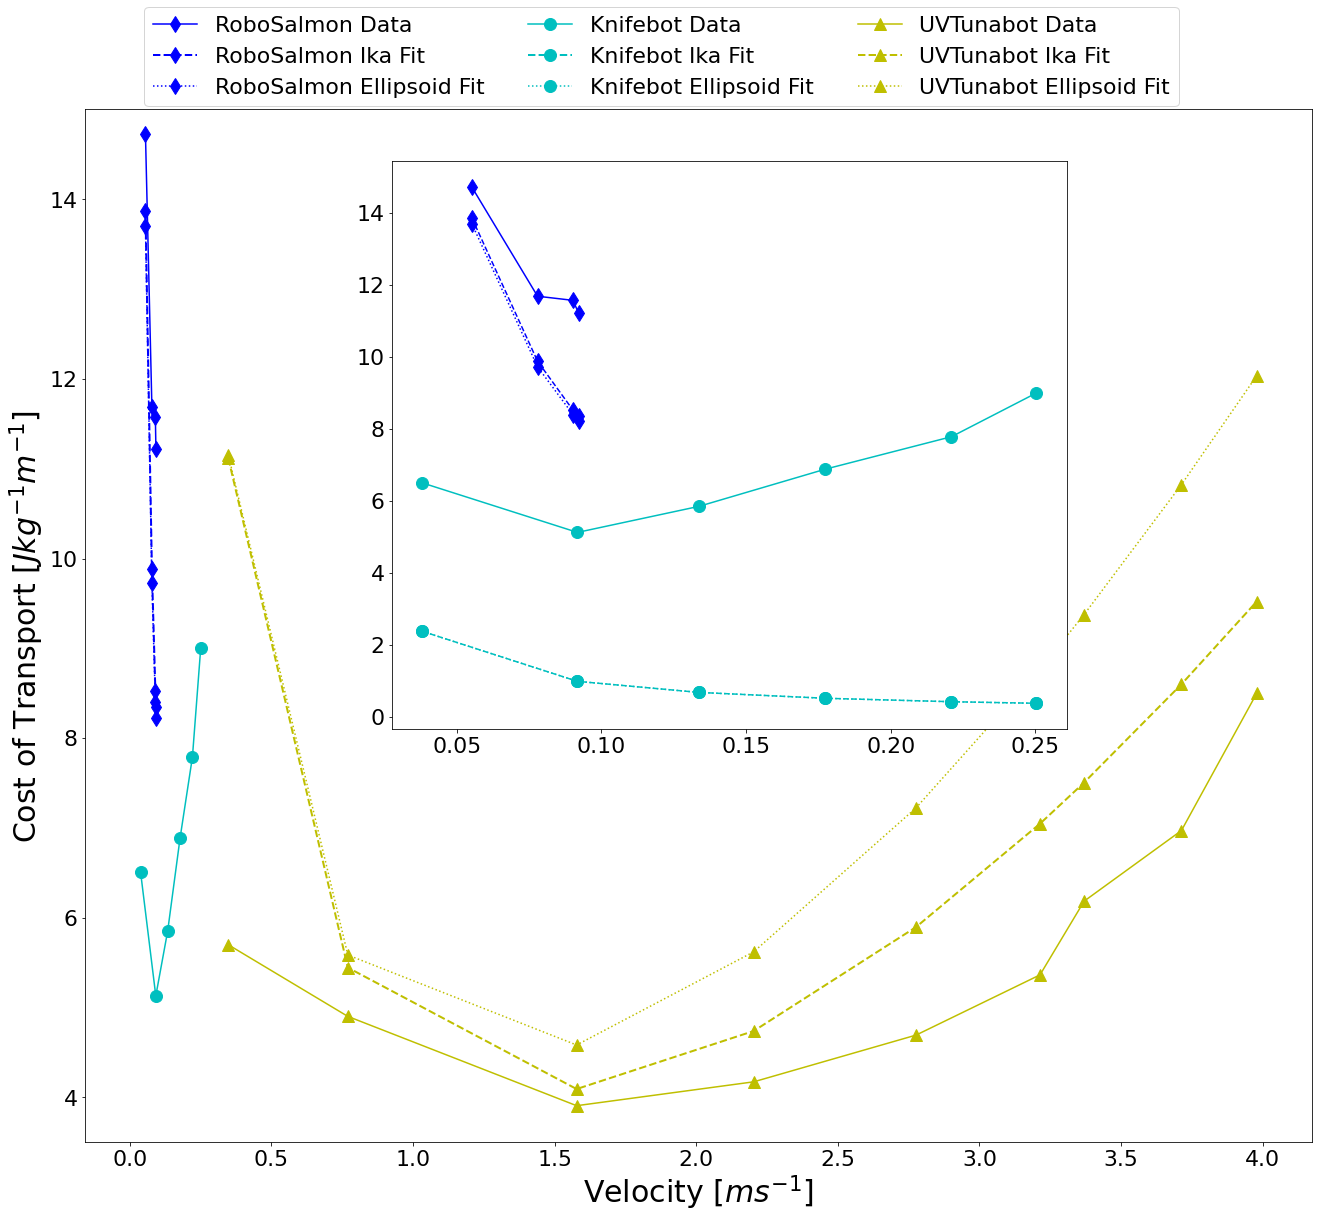

In [16]:
fig5, ax5 = plt.subplots(figsize=(22,19))

# roboSalmon Data
ax5.plot(roboSalmon_cot["Velocity"], roboSalmon_cot["COT_Raw"], 'bd-', label='RoboSalmon Data')
#ax5.plot(killerWhale_cot["Velocity"].values, power_law(killerWhale_cot["Velocity"].values, *popt_orca), 'b-')
ax5.plot(roboSalmon_cot["Velocity"], roboSalmon_cot["COT_calc"], 'bd--', label="RoboSalmon Ika Fit", linewidth=2)
ax5.plot(roboSalmon_cot["Velocity"], roboSalmon_cot["COT_Ellipse"], 'bd:', label="RoboSalmon Ellipsoid Fit")

# faKnifefish
ax5.plot(faKnifefish_cot["Velocity"], faKnifefish_cot["COT_Raw"], 'co-', label='Knifebot Data')
#ax5.plot(carp_cot["Velocity"].values, power_law(carp_cot["Velocity"].values, *popt_carp), 'c-', label='Carp Data')
ax5.plot(faKnifefish_cot["Velocity"], faKnifefish_cot["COT_calc"], 'co--', label="Knifebot Ika Fit", linewidth=2)
ax5.plot(faKnifefish_cot["Velocity"], faKnifefish_cot["COT_Ellipse"], 'co:', label="Knifebot Ellipsoid Fit")

# uvTunabot
ax5.plot(uvTunabot_cot["Velocity"], uvTunabot_cot["COT_Raw"], 'y^-', label='UVTunabot Data')
#ax5.plot(sturgeon_cot["Velocity"].values, power_law(sturgeon_cot["Velocity"].values, *popt_sturgeon), 'y-', label='Sturgeon Data')
ax5.plot(uvTunabot_cot["Velocity"], uvTunabot_cot["COT_calc"], 'y^--', label="UVTunabot Ika Fit", linewidth=2)
ax5.plot(uvTunabot_cot["Velocity"], uvTunabot_cot["COT_Ellipse"], 'y^:', label="UVTunabot Ellipsoid Fit")

ax6 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax5, [0.25,0.4,0.55,0.55])
ax6.set_axes_locator(ip)
#mark_inset(ax5, ax6, loc1=2, loc2=4, fc="none", ec='0.5')

ax6.plot(roboSalmon_cot["Velocity"], roboSalmon_cot["COT_Raw"], 'bd-')
#ax5.plot(killerWhale_cot["Velocity"].values, power_law(killerWhale_cot["Velocity"].values, *popt_orca), 'b-', label='Killer Whale Data')
ax6.plot(roboSalmon_cot["Velocity"], roboSalmon_cot["COT_Ellipse"], 'bd:')
ax6.plot(roboSalmon_cot["Velocity"], roboSalmon_cot["COT_calc"], 'bd--')

ax6.plot(faKnifefish_cot["Velocity"], faKnifefish_cot["COT_Raw"], 'co-')
#ax5.plot(faKnifefish_cot["Velocity"].values, power_law(faKnifefish_cot["Velocity"].values, *popt_silverEel), 'r-')
ax6.plot(faKnifefish_cot["Velocity"], faKnifefish_cot["COT_Ellipse"], 'co:')
ax6.plot(faKnifefish_cot["Velocity"], faKnifefish_cot["COT_calc"], 'co--')

ax5.set_ylim([3.5, 15])

ax5.set_xlabel("Velocity $[ms^{-1}]$", fontsize=30)
ax5.set_ylabel("Cost of Transport $[Jkg^{-1}m^{-1}]$", fontsize=30)
ax5.legend(loc='best', ncol=3, bbox_to_anchor=(0.9, 1.11))

fig5.savefig(Path(figurePath).joinpath('robot_COT.pdf'), facecolor='w', bbox_inches='tight', dpi=300)